In [4]:
# let's import the libraries we're going to use

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iso3166 import countries

# Business Understanding

I wanted to compare my intuition about LGBT against data collected in a survey conducted throughout the EU (and Croatia) by the FRA (European Union Agency for Fundamental Rights). The survey details can be read https://fra.europa.eu/sites/default/files/eu-lgbt-survey-technical-report_en.pdf.

I asked myself the 3 following questions:

- Question 1: do LGBT people feel less discriminated in Germany compared to France?
- Question 2: do transgenders feel more discriminated than other categories?
- Question 3: is there a diagonal in Europe?



## Data Understanding

The total amount of respondants is 93 079.

The survey posseses 5 datasets, around the topics of discrimination, rights awareness, daily life and violence & harassment.

## Methodology

The goal was to create a acceptance score from the given answers. From this score, we can compare discrimination within countries or subsets.

In the case of this analysis, only the discrimination dataset was used. The responses were of 3 categories:

- free text
- yes/no/don't know
- very rare/rare/often/very often/don't know Only the yes/no questions were selected, excluding the others.

1.normalising percentages 
Each answer is given with a percentage but we cannot use them as is because the ratio of Lesbians/Gays/Bisexuals/Transgenders is normal equal within the countries. Therefore, the percentages have been normalised with the weight of each subset.

2. setting a score for yes/no/don't know answers 
In order to create the acceptance score, each answer type was given a score.
- Don't know answers were given N/A and were dropped from the analysis
- Yes was given -1 (because pointing to more discrimination)
- No was given 1

3. setting the discrimation score 
The answer score and the weighted percentages were combined to give the acceptance score.


### Who are the respondants

#### Load the subset dataset

In [2]:
subset_size_df = pd.read_csv('./data/LGBT_Survey_SubsetSize.csv')
print(subset_size_df.shape)

(29, 7)


#### rework the dataset

In [3]:
# set country names from codes
def countryNameFromCode(serie):
    """ 
    Returns the country name associated with the given country code
  
    Parameters: 
    arg1 (string): Code of the country
  
    Returns: 
    string: Name of the country
  
    """
    country = countries.get(serie['CountryID'])
    return country.name

countryNames = subset_size_df[1:].apply(lambda row: countryNameFromCode(row), axis=1)
subset_size_df.insert(1, column='CountryName', value=countryNames)

# countries happen to change names :(
subset_size_df['CountryName'] = subset_size_df['CountryName'].str.replace('Czechia', 'Czech Republic')

# and Brexit happened
subset_size_df['CountryName'] = subset_size_df['CountryName'].str.replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')

# Lesbian women and Gay men need to be renamed for further matching with other files
subset_size_df.rename(columns={'Lesbian women': 'Lesbian', 'Gay men':'Gay'}, inplace=True)


In [4]:
# create dataframe with amount of respondants per category
labels = subset_size_df.columns[3:]
print(labels.shape)
print(labels)


(5,)
Index(['Lesbian', 'Gay', 'Bisexual women', 'Bisexual men', 'Transgender'], dtype='object')


In [5]:
sum_of_respondants = subset_size_df.iloc[1][3:]
print(sum_of_respondants)

Lesbian            437
Gay               1558
Bisexual women     164
Bisexual men       217
Transgender        167
Name: 1, dtype: object


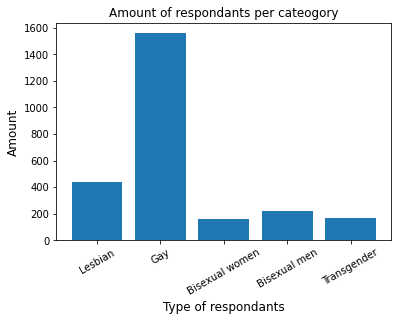

In [6]:
index = np.arange(len(labels))
plt.bar(index, sum_of_respondants)
plt.xlabel('Type of respondants', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(index, labels, fontsize=10, rotation=30)
plt.title('Amount of respondants per cateogory')
plt.show()


#### Observations
We can clearly see a predominence of gay men among the respondants. 

### Where do respondants live?

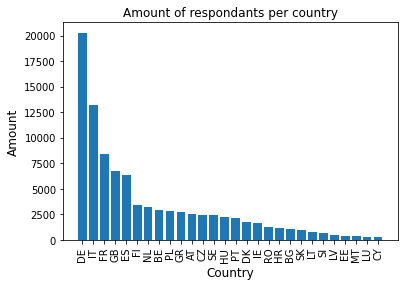

In [7]:
respondants_per_country_df = subset_size_df[['CountryID', 'N']][1:].sort_values(by='N', ascending=False)

labels = respondants_per_country_df['CountryID']
values = respondants_per_country_df['N']

index = np.arange(len(labels))
plt.bar(index, values)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.xticks(index, labels, fontsize=10, rotation=90)
plt.title('Amount of respondants per country')
plt.show()

#### Observations
The top 5 countries are Germany, Italy, France, Great Britain and Spain.
No surprise, the top most represented countries are also the most populated countries in Europe.

# Prepare Data

In [30]:
# create new weighted column for each subset
for col in subset_size_df[1:].loc[:,'Lesbian':]:
    subset_size_df[col + ' weight'] = subset_size_df[col] / subset_size_df['N']
    
subset_size_df = subset_size_df.round(2)
subset_size_df.head()

,CountryID,CountryName,N,Lesbian,Gay,Bisexual women,Bisexual men,Transgender,Lesbian weight,Gay weight,Bisexual women weight,Bisexual men weight,Transgender weight
0,EU Total,NaN,93079,15236,57448,6424,7200,6771,0.16,0.62,0.07,0.08,0.07
1,AT,Austria,2543,437,1558,164,217,167,0.17,0.61,0.06,0.09,0.07
2,BE,Belgium,2901,424,1998,132,182,165,0.15,0.69,0.05,0.06,0.06
3,BG,Bulgaria,1033,226,474,139,88,106,0.22,0.46,0.13,0.09,0.10
4,CY,Cyprus,265,41,164,18,17,25,0.15,0.62,0.07,0.06,0.09


#### Filter discrimination dataset
In the case of this project, we'll only look at answers that have yes/no/don't know answers. 
Other questions have other types of enumerations as answers so we could apply a similar logic in terms of weighting.

In [10]:
discrimination_df = pd.read_csv('./data/LGBT_Survey_Discrimination.csv')
print(discrimination_df.shape)

# select questions that only have yes/no/don't know answers
subset_questions = ['c2a_a', 'c2a_b', 'c2a_c', 'c2a_d', 'c2_b', 'c2_c', 'c4_a', 'c4_b', 'c4_c', 'c4_d', 'c4_e', 'c4_f', 'c4_g', 'c4_h', 'c4_i', 'c4_j', 'c4_k', 'c6', ]

discrimination_df = discrimination_df[discrimination_df['question_code'].isin(subset_questions)]
print(discrimination_df.shape)


(15775, 7)
(6438, 7)


#### Dropping rows

In [11]:
# drop Average rows
# these rows represent the average score per question, it is metadata
# we are not interested by this average in our score computation
index_names = discrimination_df[ discrimination_df['CountryCode'] == 'Average' ].index 
discrimination_df.drop(index_names, inplace = True) 
print(discrimination_df.shape)

# drop rows with ':' percentage
# ':' is the equivalent of N/A in that dataset
# as I'm already dropping the 'dont know' answers, these ones can be dropped too
index_names = discrimination_df[ discrimination_df['percentage'] == ':' ].index 
discrimination_df.drop(index_names, inplace = True) 
print(discrimination_df.shape)

(6216, 7)
(5667, 7)


#### Set weighted answer 

In [12]:
def setAnswerWeight(serie):
    """ 
    Returns the score associated to the answer variable of a Pandas Serie
  
    Parameters: 
    arg1 (Serie): A row in the dataset
  
    Returns: 
    Int | NaN: The score associated to the answer
  
    """

    if serie['answer'] == 'Yes':
        return -1
    elif serie['answer'] == 'No':
        return 1
    else:
        return np.NaN;

# adding weights
discrimination_df['answer_weighted'] = discrimination_df.apply(lambda serie: setAnswerWeight(serie), axis=1)

# let's see the shape now, we should see one more column
print(discrimination_df.shape)

# let's filter out the N/A on answer-weighted
discrimination_df = discrimination_df.dropna(subset=['answer_weighted'], axis=0)

# let's see the shape now, we should see less rows (approx 1/3 smaller)
print(discrimination_df.shape)

(5667, 8)
(3778, 8)


#### Set weighted percentage 

In [33]:
subset_size_df.head()

,CountryID,CountryName,N,Lesbian,Gay,Bisexual women,Bisexual men,Transgender,Lesbian weight,Gay weight,Bisexual women weight,Bisexual men weight,Transgender weight
0,EU Total,NaN,93079,15236,57448,6424,7200,6771,0.16,0.62,0.07,0.08,0.07
1,AT,Austria,2543,437,1558,164,217,167,0.17,0.61,0.06,0.09,0.07
2,BE,Belgium,2901,424,1998,132,182,165,0.15,0.69,0.05,0.06,0.06
3,BG,Bulgaria,1033,226,474,139,88,106,0.22,0.46,0.13,0.09,0.10
4,CY,Cyprus,265,41,164,18,17,25,0.15,0.62,0.07,0.06,0.09


In [34]:
discrimination_df.head(10)

,CountryCode,subset,question_code,question_label,answer,percentage,notes,answer_weighted
1250,Austria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,36,NaN,-1.0
1251,Austria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,58,NaN,1.0
1253,Belgium,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,30,NaN,-1.0
1254,Belgium,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,61,NaN,1.0
1256,Bulgaria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,33,NaN,-1.0
1257,Bulgaria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,60,NaN,1.0
1262,Czech Republic,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,39,NaN,-1.0
1263,Czech Republic,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,58,NaN,1.0
1265,Germany,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,31,NaN,-1.0
1266,Germany,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,63,NaN,1.0


In [35]:
def setWeightedPercentage(serie, population_weights_df):
    """ 
    Applies a weight on percentages
    
    This function matches the percentage column of a Pandas Serie with weights from another dataset. 
    It creates a weighted percentage.
  
    Parameters: 
    arg1 (Serie): A row in the dataset
    arg2 (DataFrame): a dataframe with population weights
  
    Returns: 
    Int: The weighted percentage
  
    """
    # weighted population
    category = serie['subset']
    population_weights_for_country = population_weights_df[population_weights_df['CountryName'] == serie['CountryCode']]
    populationWeight = population_weights_for_country[category +' weight']
    weightedPercentage = float(serie['percentage']) * float(populationWeight)
    return weightedPercentage
    
    
discrimination_df['percentage_weighted'] = discrimination_df.apply(lambda serie: setWeightedPercentage(serie, subset_size_df), axis=1)
discrimination_df.head()

,CountryCode,subset,question_code,question_label,answer,percentage,notes,answer_weighted,percentage_weighted
1250,Austria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,36,NaN,-1.0,2.52
1251,Austria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,58,NaN,1.0,4.06
1253,Belgium,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,30,NaN,-1.0,1.80
1254,Belgium,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,61,NaN,1.0,3.66
1256,Bulgaria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,33,NaN,-1.0,3.30


#### Set weighted score

In [42]:
def setWeightedScore(serie):
    """ 
    Creates a weighted score
  
    Parameters: 
    arg1 (Serie): A row in the dataset
  
    Returns: 
    Int: The weighted score
  
    """
    score = serie['answer_weighted'] * (serie['percentage_weighted']/100)
    return score
    
    
discrimination_df['acceptance_score'] = discrimination_df.apply(lambda serie: setWeightedScore(serie), axis=1)
discrimination_df.head()

,CountryCode,subset,question_code,question_label,answer,percentage,notes,answer_weighted,percentage_weighted,score,acceptance_score
1250,Austria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,36,NaN,-1.0,2.52,-0.0252,-0.0252
1251,Austria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,58,NaN,1.0,4.06,0.0406,0.0406
1253,Belgium,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,30,NaN,-1.0,1.80,-0.0180,-0.0180
1254,Belgium,Transgender,c2a_a,"In the last 12 months, in the country where yo...",No,61,NaN,1.0,3.66,0.0366,0.0366
1256,Bulgaria,Transgender,c2a_a,"In the last 12 months, in the country where yo...",Yes,33,NaN,-1.0,3.30,-0.0330,-0.0330


# Modeling

## Grouping by country

In [43]:
discrimination_scores_per_country = discrimination_df[['CountryCode', 'acceptance_score']].groupby(by=['CountryCode']).sum().sort_values(by=['score'], ascending=False)

KeyError: 'score'

## Grouping by subset

In [44]:
discrimination_scores_per_subset = discrimination_df[['subset', 'acceptance_score']].groupby(by=['subset']).sum().sort_values(by=['score'], ascending=False)

KeyError: 'score'

# Analysis

## Question 1: do LGBT people feel less discriminated in Germany compared to France?

I am french but I'm living in Berlin since 8 years. My gut feeling says there's more acceptance towards LGBT people in Germany than in France but I would like to go through the data and look at what we can find out regarding this question.
I also have to take personal biases into account. I was born and grew up in a very small village in south of France, which is not quite representative of the whole french population. Similarly for Germany, I've only lived in Berlin which seems much more LGBT-friendly that many other places, including the rest of Germany.

So let's see what we can see from the data:


In [45]:
discrimination_scores_per_country.head(30)

,score
CountryCode,
Netherlands,11.2761
Denmark,11.1666
Belgium,10.8153
Czech Republic,10.7545
Spain,10.5499
Finland,10.5426
Sweden,10.2839
Germany,9.9541
France,9.9200


####Conclusion 
The data seem to indicate there is not much real difference between France and Germany.

## Question 2: do transgenders feel more discriminated than other categories?

My gut feeling is that there is more discrimination towards transgenders than towards homosexuals or bisexuals.


In [46]:
discrimination_scores_per_subset.head()

,score
subset,
Gay,156.2240
Lesbian,46.7058
Bisexual women,23.7693
Bisexual men,18.6038
Transgender,14.5025


#### Conclusion 
The data seems to indicate that yes, transgenders seem to be/feel more discriminated than the other members of the LGBT people.

## Question 3: is there a diagonal in Europe?

I've got to travel quite a bit and have had the chance to meet people from many many different countries. I'd say that Scandinavia and western Europe tend to be acceptive towards LGBT, while eastern Europe would be on the other side of the spectrum.

In [47]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=subset_size_df['CountryName'],
    z=discrimination_scores_per_country['score'].astype(float),
    locationmode='country names',
    colorscale='Hot',
    autocolorscale=False,
    text="", # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Acceptance score"

))
fig.update_geos(
    fitbounds="locations",
    resolution=110,
    visible=False,
    showframe=False,
    projection={"type": "mercator"},
    scope="europe"
)
fig.show()

#### What can we infer from that?

- it seems there is more discrimination in eastern and southern Europe but it's not a standard.
- The UK case is quite puzzling, I'm wondering whether this is anomaly or not.


# Improvements to the analysis

A few things could have been made better, such as:

- use the entire discrimination dataset instead of a subset of it
- use all the four other datasets because they also relate to discrimination questions
